# Weather Forecasting

### 기온 정보가 들어있는 시계열 데이터를 LSTM으로 학습한 후, 10시간 후의 기온을 예측할때 전처리 및 데이터 구성을 위해 keras 내장 함수를 활용해본다

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from zipfile import ZipFile
import os

#기후 정보가 들어있는 데이터 다운로드
zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
fname='jena_climate_2009_2016.csv.zip', extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [2]:
#데이터에서 온도 정보만을 추출한 후, 30만개 데이터를 학습데이터로 사용
df = pd.read_csv(csv_path)
temperature_data=np.array(df["T (degC)"])
train_data=temperature_data[:300000]
train_mean,train_std =np.mean(train_data),np.std(train_data)
train_data=(train_data-train_mean)/train_std
train_data=np.expand_dims(np.array(train_data),-1)

In [3]:
sequencelength=200 #학습 데이터를 200개 단위로 잘라서 학습
predict_step=60 #10시간 후가 60개 데이터 포인트이므로, 라벨 데이터로 x1 데이터의 60 step 이후의 데이터를 y1데이터로 설정
batch_size=1024 #batch size 설정

In [4]:
#데이터를 sequence length 길이로 직접 자르는 작업없이 keras.preprocessing.timeseries_dataset_from_array를 이용하여 train dataset 구성
datax=train_data[:-(sequencelength+predict_step)]
datay=train_data[sequencelength+predict_step:]
train_dataset = keras.preprocessing.timeseries_dataset_from_array(datax, datay, sequence_length=sequencelength, batch_size=batch_size)

In [5]:
feature_number=1 #feature:T (degC)
inputs = keras.Input(shape=(sequencelength,feature_number))
x = layers.LSTM(units=100)(inputs) #LSTM layer로 학습 모델을 구성
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=["mean_squared_error"])

# loss 및 metric으로 mse 설정
model.fit(train_dataset,epochs=100)

Epoch 1/100
293/293 [==============================] - 16s 55ms/step - loss: 0.4368 - mean_squared_error: 0.4368
Epoch 2/100
293/293 [==============================] - 17s 58ms/step - loss: 0.3926 - mean_squared_error: 0.3926
Epoch 3/100
293/293 [==============================] - 17s 58ms/step - loss: 0.3830 - mean_squared_error: 0.3830
Epoch 4/100
293/293 [==============================] - 16s 56ms/step - loss: 0.3782 - mean_squared_error: 0.3782
Epoch 5/100
293/293 [==============================] - 17s 59ms/step - loss: 0.3775 - mean_squared_error: 0.3775
Epoch 6/100
293/293 [==============================] - 17s 58ms/step - loss: 0.3724 - mean_squared_error: 0.3724
Epoch 7/100
293/293 [==============================] - 16s 54ms/step - loss: 0.3721 - mean_squared_error: 0.3721
Epoch 8/100
293/293 [==============================] - 16s 54ms/step - loss: 0.3659 - mean_squared_error: 0.3659
Epoch 9/100
293/293 [==============================] - 16s 55ms/step - loss: 0.3463 - mean_squar

In [6]:
#최종 train data mse 측정
metrics=model.evaluate(train_dataset, verbose=2)
print("Train Data MSE:", metrics[1])

293/293 - 13s - loss: 0.1157 - mean_squared_error: 0.1157
Train Data MSE: 0.11570044606924057


## predict

In [28]:
#학습 데이터 30만장 이후의 6만장을 테스트 데이터로 설정
test_data=temperature_data[300000:360000]
test_mean,test_std =np.mean(test_data),np.std(test_data)
test_data=(test_data-test_mean)/test_std
test_data=np.expand_dims(np.array(test_data),-1)

In [29]:
#test dataset 구성
test_datax=test_data[:-(sequencelength+predict_step)]
test_datay=test_data[sequencelength+predict_step:]
test_dataset = keras.preprocessing.timeseries_dataset_from_array(test_datax, test_datay, sequence_length=sequencelength, batch_size=batch_size)

In [33]:
#최종 test data mse 측정
metrics=model.evaluate(test_dataset, verbose=2)
print("Test Data MSE:", metrics[1])

59/59 - 3s - loss: 0.1613 - mean_squared_error: 0.1613
Test Data MSE: 0.1612764596939087


## plot result

In [38]:
#sample test data
for x, y in test_dataset.take(1):
    sample_testx=x
    sample_testy=y

#predcit sample data
predict_results=model.predict(sample_testx)

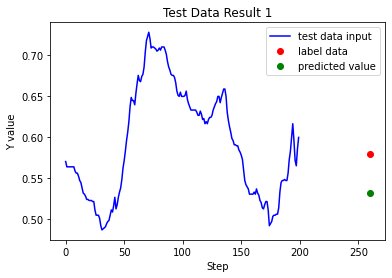

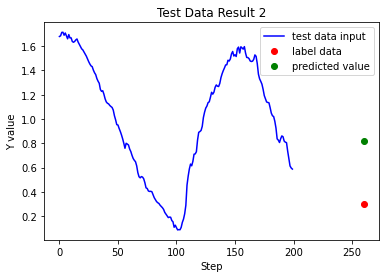

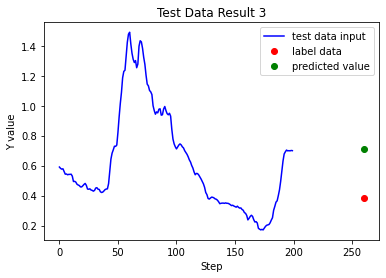

In [39]:
#test data and predicted value plot
step=np.array(range(0,261))
plt.title("Test Data Result 1")
plt.xlabel("Step")
plt.ylabel("Y value")
plt.plot(np.array(range(0,200)), sample_testx[0], 'b', label='test data input')
plt.plot([260], sample_testy[0], 'ro', label='label data')
plt.plot([260], predict_results[0],'go', label='predicted value')
plt.legend()
plt.show()
plt.title("Test Data Result 2")
plt.xlabel("Step")
plt.ylabel("Y value")
plt.plot(np.array(range(0,200)), sample_testx[500], 'b', label='test data input')
plt.plot([260], sample_testy[500], 'ro', label='label data')
plt.plot([260], predict_results[500],'go', label='predicted value')
plt.legend()
plt.show()
plt.title("Test Data Result 3")
plt.xlabel("Step")
plt.ylabel("Y value")
plt.plot(np.array(range(0,200)), sample_testx[1000], 'b', label='test data input')
plt.plot([260], sample_testy[1000], 'ro', label='label data')
plt.plot([260], predict_results[1000],'go', label='predicted value')
plt.legend()
plt.show()